In [1]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 3019), started 2 days, 3:22:07 ago. (Use '!kill 3019' to kill it.)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from functools import partial
from numpy.random import default_rng
import matplotlib.pyplot as plt
rng = default_rng()


In [3]:
SEED = 42
PROJECT_FOLDER = "../input/hotel-id-to-combat-human-trafficking-2022-fgvc9/"
TRAIN_DATA_FOLDER = PROJECT_FOLDER + "train_images/"
TEST_DATA_FOLDER = PROJECT_FOLDER + "test_images/"

IMAGE_SIZE = (224, 224)
input_size = 224
VAL_SPLIT = 0.1

In [4]:
train_ds = image_dataset_from_directory(
    directory=TRAIN_DATA_FOLDER,
    labels='inferred',
    label_mode='categorical',
    batch_size=10,
    seed=1337,
    image_size=IMAGE_SIZE,
    crop_to_aspect_ratio=True,
    subset='training',
    validation_split=VAL_SPLIT
)

val_ds = image_dataset_from_directory(
    directory=TRAIN_DATA_FOLDER,
    labels='inferred',
    label_mode='categorical',
    batch_size=10,
    seed=1337,
    image_size=IMAGE_SIZE,
    crop_to_aspect_ratio=True,
    subset='validation',
    validation_split=VAL_SPLIT
)

test_ds = image_dataset_from_directory(
    directory=TEST_DATA_FOLDER,
    labels=None,
    batch_size=1,
    seed=1337,
    image_size=IMAGE_SIZE,
    crop_to_aspect_ratio=True,
)


Found 44703 files belonging to 3116 classes.
Using 40233 files for training.


2022-05-25 16:37:47.496638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-25 16:37:47.553075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-25 16:37:47.553552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-25 16:37:47.556331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Found 44703 files belonging to 3116 classes.
Using 4470 files for validation.
Found 14 files belonging to 1 classes.


In [5]:
n_classes = len(train_ds.class_names)
n_classes

3116

In [6]:
def augment_using_ops(images, labels):
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_brightness(images, 0.2)
    images = tf.image.random_contrast(images, 0.1, 0.6)
    return (images, labels)

train_ds_aug = train_ds.map(augment_using_ops)
val_ds_aug = train_ds.map(augment_using_ops)

In [7]:
def random_cutout(images_tensor, labels):
    ratios_x = rng.uniform(0.1, 0.4)*images_tensor.shape[1]
    ratios_y = rng.uniform(0.1, 0.4)*images_tensor.shape[2]

    xs_mask = tf.cast(ratios_x, tf.int32)
    xs_mask = xs_mask if xs_mask % 2 == 0 else xs_mask+1 # force number even

    ys_mask = tf.cast(ratios_y, tf.int32)
    ys_mask = ys_mask if ys_mask % 2 == 0 else ys_mask+1 # force number even

    return tfa.image.random_cutout(images_tensor, (xs_mask, ys_mask), constant_values = (255.0, 0.0, 0.0)), labels

train_ds_aug = train_ds_aug.map(random_cutout)
val_ds_aug = val_ds_aug.map(random_cutout)

In [8]:
a = next(iter(train_ds_aug))

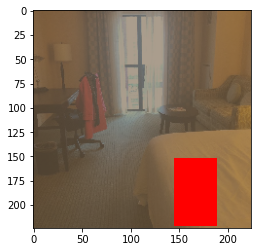

In [9]:
plt.imshow(a[0][0]/255.0)

# Models

In [10]:

def create_baseline_efficientnet_model(n_classes):
    efficientnet_layer = tf.keras.applications.EfficientNetB0(
            include_top=True,
            weights="imagenet")
    efficientnet_layer.trainable = False
    
    model = keras.Sequential([
        efficientnet_layer,
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(1000, activation='selu'),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(1000, activation='selu'),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(n_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-2),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
  


In [11]:
def create_finetuned_efficientnet_model(n_classes):
    efficientnet_layer = tf.keras.applications.EfficientNetB0(
            include_top= False,
            weights="imagenet")
    efficientnet_layer.trainable = False
    
    model = keras.Sequential([
        efficientnet_layer,
        keras.layers.GlobalAveragePooling2D(name = "avg_pool"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(n_classes, activation = 'softmax')
    ])
    
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-2),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [12]:
def create_unfreezed_efficientnet_model(model):
    for layer in model.layers[-35:]:
        if not isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable = True
    
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [13]:
model = create_finetuned_efficientnet_model(n_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3116)              3991596   
                                                                 
Total params: 8,046,287
Trainable params: 3,994,156
Non-

In [14]:
callbacks = [
    tf.keras.callbacks.TensorBoard(
        log_dir = 'logs'
    ), 
    tf.keras.callbacks.ModelCheckpoint(
        filepath='ckp',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
]

In [15]:
history = model.fit(train_ds_aug, epochs=50, callbacks=callbacks, validation_data=val_ds_aug)
model.save('../models/fine_tuned_effb0.h5')

Epoch 1/50


2022-05-25 16:38:37.151546: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-05-25 16:38:38.964221: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-25 16:38:38.981892: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-25 16:38:38.981953: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-05-25 16:38:38.997569: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-25 16:38:38.997695: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


   1/4024 [..............................] - ETA: 11:06:43 - loss: 7.9002 - accuracy: 0.0000e+00

2022-05-25 16:38:41.571390: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4024/4024 [==============================] - 488s 119ms/step - loss: 7.8362 - accuracy: 0.0824 - val_loss: 6.2992 - val_accuracy: 0.1238
Epoch 2/50
4024/4024 [==============================] - 477s 119ms/step - loss: 6.4998 - accuracy: 0.1074 - val_loss: 6.3473 - val_accuracy: 0.1345
Epoch 3/50
4024/4024 [==============================] - 473s 117ms/step - loss: 5.9226 - accuracy: 0.1583 - val_loss: 6.4929 - val_accuracy: 0.1567
Epoch 4/50
4024/4024 [==============================] - 475s 118ms/step - loss: 5.6598 - accuracy: 0.2093 - val_loss: 6.8248 - val_accuracy: 0.1678
Epoch 5/50
4024/4024 [==============================] - 11268s 3s/step - loss: 5.6154 - accuracy: 0.2366 - val_loss: 7.2548 - val_accuracy: 0.1776
Epoch 6/50
4024/4024 [==============================] - 549s 136ms/step - loss: 5.6265 - accuracy: 0.2636 - val_loss: 7.7265 - val_accuracy: 0.1876
Epoch 7/50
4024/4024 [==============================] - 553s 137ms/step - loss: 5.6905 - accuracy: 0.2889 - val_loss: 7.9531

In [18]:
model = create_unfreezed_efficientnet_model(tf.keras.models.load_model('../models/fine_tuned_effb0.h5'))
history2 = model.fit(train_ds_aug, epochs=50, callbacks=callbacks, validation_data=val_ds_aug)
model.save('../models/fine_tuned_effb0_complete.h5')

Epoch 1/50
4024/4024 [==============================] - 1075s 265ms/step - loss: 0.5005 - accuracy: 0.8658 - val_loss: 0.2552 - val_accuracy: 0.9450
Epoch 2/50
4024/4024 [==============================] - 4228s 1s/step - loss: 0.4611 - accuracy: 0.8773 - val_loss: 0.2982 - val_accuracy: 0.9405
Epoch 3/50
4024/4024 [==============================] - 926s 230ms/step - loss: 0.4255 - accuracy: 0.8847 - val_loss: 0.2401 - val_accuracy: 0.9464
Epoch 4/50
4024/4024 [==============================] - 914s 227ms/step - loss: 0.4285 - accuracy: 0.8839 - val_loss: 0.2632 - val_accuracy: 0.9440
Epoch 5/50
4024/4024 [==============================] - 909s 226ms/step - loss: 0.3986 - accuracy: 0.8907 - val_loss: 0.3396 - val_accuracy: 0.9328
Epoch 6/50
4024/4024 [==============================] - 908s 226ms/step - loss: 0.3910 - accuracy: 0.8936 - val_loss: 0.2576 - val_accuracy: 0.9447
Epoch 7/50
4024/4024 [==============================] - 914s 227ms/step - loss: 0.3836 - accuracy: 0.8972 - val_l

KeyboardInterrupt: 

In [19]:
model.save('../models/fine_tuned_effb0_complete.h5')

In [ ]:
model.evaluate(test_ds)

1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

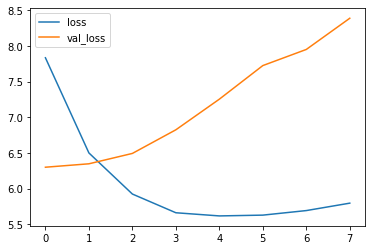

In [20]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
model.save('empanadanet.h5')